In [6]:
!pip install opendatasets

## Import required package

In [7]:
import numpy as np
import os
import matplotlib.pyplot as plt
import opendatasets as od
import time
from IPython import display

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Conv2DTranspose, LeakyReLU,\
                                    Reshape, Activation, ReLU, Flatten
from tensorflow.keras.activations import tanh
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist


## Image configuration:

In [8]:
IMG_SIZE=64
IMG_CHANNELS=3

NOISE_DIMS=100

BATCH_SIZE = 128

## Prepare data

In [9]:
# Dataset link : https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset
od.download_kaggle_dataset("https://www.kaggle.com/datasets/jeffheaton/glasses-or-no-glasses", '.')

Skipping, found downloaded files in "./glasses-or-no-glasses" (use force=True to force download)


In [10]:
dataset = keras.utils.image_dataset_from_directory('/content/glasses-or-no-glasses/faces-spring-2020',
                                       labels=None,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True,
                                       image_size=(IMG_SIZE , IMG_SIZE),
                                       )

Found 5000 files belonging to 1 classes.


In [11]:
def prepare_dataset(dataset, batch_size, buffer_size, shuffle=True):
    dataset = dataset.batch(batch_size, drop_remainder=True)
    if shuffle:
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def preprocessing_image(image):
    # Resize the image to 64x64
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Scale value of image to range [-1, 1]
    image = tf.cast(image, tf.float32)
    image = image / 127.5 - 1.0

    return image

dataset = dataset.map(preprocessing_image)
#dataset = prepare_dataset(dataset, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE, shuffle=True)

(128, 64, 64, 3)


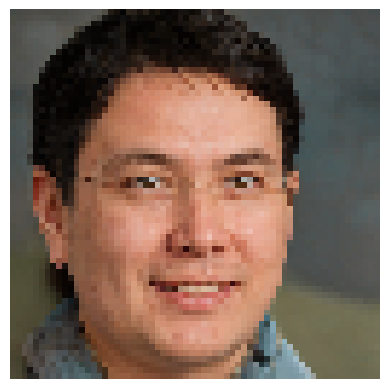

In [12]:
for image in dataset:
    print(image.shape)
    plt.imshow(((image[1] + 1.0) * 127.5).numpy().astype('uint8'))
    plt.axis('off')
    break

## Implement generator

In [13]:
# I will use the DCGAN architecture for generator

class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__()

        self.net = keras.models.Sequential(
            [
                Dense(4 * 4 * 1024, activation='relu'),
                Reshape((4, 4, 1024)),
                self._block(filters=512, kernel_size=5, strides=2, padding='same'),
                self._block(filters=256, kernel_size=5, strides=2, padding='same'),
                self._block(filters=128, kernel_size=5, strides=2, padding='same'),
                # We will not apply the batch normalization on output and use tanh activation instead of leaky relu
                Conv2DTranspose(filters=IMG_CHANNELS, kernel_size=5, strides=2, padding='same'),
                Activation(tanh)
            ]
        )

    def _block(self, filters, kernel_size, strides, padding):
        # This will implement one fractional-kernal Conv block
        return keras.models.Sequential(
            [
                Conv2DTranspose(filters=filters,
                                kernel_size=kernel_size,
                                strides=strides,
                                padding=padding,
                               kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
                               bias_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                ReLU()
            ]
        )

    def call(self, x, training=False):
        return self.net(x)

In [14]:
test_input = tf.random.uniform([BATCH_SIZE, NOISE_DIMS])

test_generator = Generator()
test_output = test_generator(test_input, training=False)
test_output.shape

TensorShape([128, 64, 64, 3])

## Implement Discriminator:

In [15]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.net = keras.models.Sequential(
            [
                # We will not apply batch normalization on the input of Critic
                Conv2D(filters=128, kernel_size=5, strides=2, padding='same',
                      kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
                      bias_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
                LeakyReLU(alpha=0.2),
                self._block(filters=256, kernel_size=5, strides=2, padding='same'),
                self._block(filters=512, kernel_size=5, strides=2, padding='same'),
                self._block(filters=1024, kernel_size=5, strides=2, padding='same'),
                Conv2D(filters=1, kernel_size=4, strides=2, padding='valid'),
                Flatten()
            ]
        )

    def _block(self, filters, kernel_size, strides, padding):
        # This will implement one Conv block
        return keras.models.Sequential(
            [
                Conv2D(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding=padding,
                      kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02),
                      bias_initializer=initializers.RandomNormal(mean=0.0, stddev=0.02)),
                BatchNormalization(),
                LeakyReLU(alpha=0.2)
            ]
        )

    def call(self, x, training=False):
        return self.net(x)

In [16]:
test_input = tf.random.uniform([BATCH_SIZE, IMG_SIZE, IMG_SIZE, IMG_CHANNELS])

test_discriminator = Discriminator()
test_output = test_discriminator(test_input)

test_output.shape

TensorShape([128, 1])

## Implement loss function

In [17]:
def discriminator_loss(critic_real, critic_fake):
    # max E(critic_real) - E(critic_fake) <-> min -(E(critic_real) - E(critic_fake))
    return -(tf.reduce_mean(critic_real) - tf.reduce_mean(critic_fake))

def generator_loss(critic_fake):
    # max E[critic(gen_fake)] <-> min E[critic(gen_fake)]
    return -tf.reduce_mean(critic_fake)

## Training model

In [18]:
EPOCHS = 50
LEARNING_RATE = 5e-5

CRITIC_ITERATIONS = 5
CLIPPING = 0.01

# Initialize optimizer
gen_optimizer = RMSprop(learning_rate=LEARNING_RATE)
discriminator_optimizer = RMSprop(learning_rate=LEARNING_RATE)

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Create checkpoint
checkpoint_dir = './checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, 'wgan-ckpt')
checkpoint = tf.train.Checkpoint(generator=generator, discriminator=discriminator,
                                 generator_optim=gen_optimizer, discriminator_optim=discriminator_optimizer)

def generate_and_visualize(test_input):
    output_images = generator(test_input)

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow((output_images[i] * 127.5 + 127.5).numpy().astype('uint8'))
        plt.axis('off')

    plt.show()

# Helper function for plot loss
def plot_loss(g_losses, d_losses):
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

num_test_samples = 16
test_input = tf.random.normal([num_test_samples, NOISE_DIMS])
#generate_and_visualize(test_input)

Traning epoch 48 takes 261.9198904719997 seconds


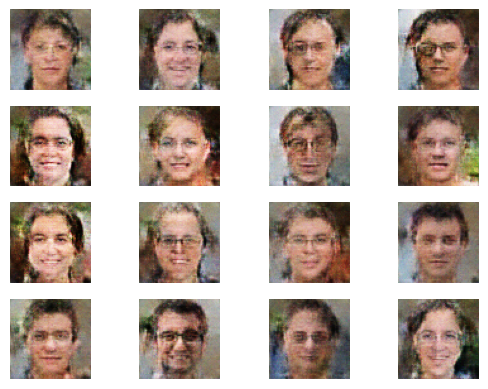

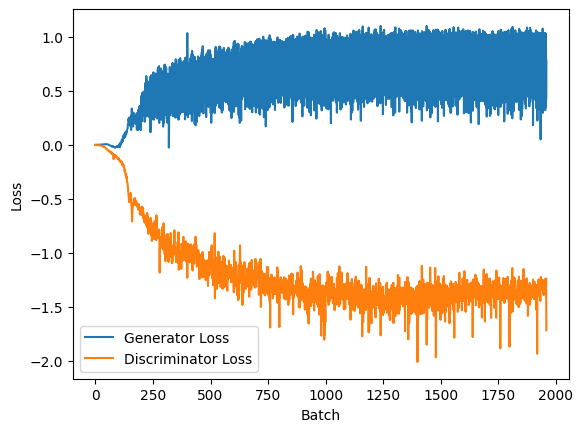

In [ ]:
G_losses = []
D_losses = []
def train(real_dataset, test_input):
    for epoch in range(EPOCHS):
        start = time.perf_counter()
        for image in real_dataset:

            # Train discriminator
            for _ in range(CRITIC_ITERATIONS):
                noise_input = tf.random.normal([image.shape[0], NOISE_DIMS])
                with tf.GradientTape() as d_tape:
                    generated_output = generator(noise_input, training=True)

                    # Calculate critic
                    critic_fake = discriminator(generated_output, training=True)
                    critic_real = discriminator(image, training=True)

                    # Calculate loss
                    d_loss = discriminator_loss(critic_real=critic_real, critic_fake=critic_fake)

                # Calculate discriminator gradients
                d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
                # Update discriminator weights
                discriminator_optimizer.apply_gradients(zip(d_grads, discriminator.trainable_variables))

                # Clipping weight for ensuring the discriminator is 1-Lipchitsz
                for l in discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -CLIPPING, CLIPPING) for w in weights]
                    l.set_weights(weights)
            D_losses.append(d_loss)

            # Train generator
            noise_input = tf.random.normal([image.shape[0], NOISE_DIMS])
            with tf.GradientTape() as g_tape:
                generated_output = generator(noise_input, training=True)

                # Calculate critic
                critic_fake = discriminator(generated_output, training=True)

                # Calculate loss
                g_loss = generator_loss(critic_fake)
            # calculate generator gradients
            g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
            # Update generator weights
            gen_optimizer.apply_gradients(zip(g_grads, generator.trainable_variables))

            G_losses.append(g_loss)
        # Monitor training process
        display.clear_output(wait=True)
        print(f'Traning epoch {epoch} takes {time.perf_counter() - start} seconds')
        generate_and_visualize(test_input)
        plot_loss(G_losses, D_losses)

        if (epoch + 1) % 10 == 0:
            checkpoint.save(checkpoint_prefix)

    print('Done!')
    # Display the last result
    display.clear_output(wait=True)
    print(f'Traning epoch {epoch} takes {time.perf_counter() - start} seconds')
    generate_and_visualize(test_input)
    plot_loss(G_losses, D_losses)

train(dataset, test_input)